## Exercici 1
Estandaritza, identifica i enumera cada un dels atributs / variables de l'estructura de l'arxiu "Web_access_log-akumenius.com" que trobaràs al repositori de GitHub "Data-sources".

In [21]:
import re

class Log:
       
    def __init__(self, log_line):
        self.log_line = log_line


    def getDate(self, string):
        full_date = re.findall(r'([0-2][0-9]|[3][0-1])[\/](Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[\/](\d{4})', string)
        day, month, year = full_date[0]
        
        if month == "Jan":
            month = "01"
        elif month == "Feb":
            month = "02"
        elif month == "Mar":
            month = "03"
        elif month == "Apr":
            month = "04"
        elif month == "May":
            month = "05"
        elif month == "Jun":
            month = "06"
        elif month == "Jul":
            month = "07"
        elif month == "Aug":
            month = "08"
        elif month == "Sep":
            month = "09"
        elif month == "Oct":
            month = "10"
        elif month == "Nov":
            month = "11"
        elif month == "Dec":
            month = "12"
        
        date = f"{day}-{month}-{year}"
        return date


    def getTime(self, string):
        time = re.findall(r':([0-9]{1,2}:[0-9]{1,2}:[0-9]{1,2})', string)[0]
        return time


    def parser(self):
        
        HOST = r'^(?P<host>.*?)'
        SPACE = r'\s'
        IP = r'(?P<ip>\d{1,3}\.\d{1,3}\.\d{1,3}.\d{1,3})'
        USER = r'(?P<user>\S+)'
        REMOTE_LOG_NAME = r'(?P<remote_log_name>\S+)'
        TIME = r'(?P<time>\[.*?\])'
        REQUEST = r'\"(?P<request>.*?)\"'
        STATUS = r'(?P<status>\d{3})'
        SIZE = r'(?P<size>\S+)'
        REFERRING_URL = r'\"(?P<referring_url>.*?)\"'
        BROWSER = r'\"(?P<browser>.*?)\"'

     
        REGEX = HOST+SPACE+IP+SPACE+REMOTE_LOG_NAME+SPACE+USER+SPACE+TIME+SPACE+REQUEST+SPACE+STATUS+SPACE+SIZE+SPACE+REFERRING_URL+SPACE+BROWSER
        match = re.search(REGEX, self.log_line)
        #host, ip = match.group('host').split(' ')
        date = self.getDate(match.group('time'))
        time = self.getTime(match.group('time'))
        action, url, protocol = match.group('request').split(' ')
        data = (
            (
                match.group('host'),
                match.group('ip'), 
                match.group('remote_log_name'),
                match.group('user'), 
                date, 
                time, 
                action,
                url,
                protocol,
                match.group('status'),
                match.group('size'),
                match.group('referring_url'),
                match.group('browser')
            )
        )
        
        return list(data)


logLine = Log("""localhost 127.0.0.1 - - [23/Feb/2014:03:10:31 +0100] "OPTIONS * HTTP/1.0" 200 - "-" "Apache (internal dummy connection)" VLOG=-""")
logLine.parser()

['localhost',
 '127.0.0.1',
 '-',
 '-',
 '23-02-2014',
 '03:10:31',
 'OPTIONS',
 '*',
 'HTTP/1.0',
 '200',
 '-',
 '-',
 'Apache (internal dummy connection)']

## Exercici 2
Neteja, preprocesa, estructura i transforma (dataframe) les dades del registre d'Accés a la web.

**Seleccionar muestra de líneas del archivo con las que trabajar**

In [22]:
import numpy as np
import pandas as pd

df_logs_original = pd.read_csv("Web_access_log-akumenius.com.txt", sep="\n")
df_logs_original = df_logs_original.sample(200)
df_logs_original = df_logs_original.iloc[:, 0]

**Parsear cada línea de la muestra**

In [23]:
all_logs_data = []

for line in df_logs_original:
    log = Log(f"{line}")
    log_data = log.parser()
    all_logs_data.append(log_data)


df_logs = pd.DataFrame(all_logs_data, columns = ["host", 
                                                 "ip", 
                                                 "remote_log_name", 
                                                 "user", 
                                                 "date", 
                                                 "time", 
                                                 "action", 
                                                 "requested_url", 
                                                 "protocol", 
                                                 "status", 
                                                 "size", 
                                                 "referring_url", 
                                                 "browser"])

**Estandarizar valores vacíos (marcados con '-' y '*') Nan**

In [24]:
df_logs = df_logs.replace('-', np.nan)
df_logs = df_logs.replace('*', np.nan)

**Convertir fechas a formato datetime y limpiar horas**

In [25]:
df_logs['date'] = pd.to_datetime(df_logs['date'])
df_logs['time'] = pd.to_datetime(df_logs['time'])
df_logs['time'] = df_logs['time'].dt.strftime('%H:%M')

**Castear status**

In [26]:
df_logs.loc[:,'status'] = df_logs['status'].astype(int)

print(df_logs.info())
print(df_logs.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   host             200 non-null    object        
 1   ip               200 non-null    object        
 2   remote_log_name  0 non-null      float64       
 3   user             0 non-null      float64       
 4   date             200 non-null    datetime64[ns]
 5   time             200 non-null    object        
 6   action           200 non-null    object        
 7   requested_url    192 non-null    object        
 8   protocol         200 non-null    object        
 9   status           200 non-null    int64         
 10  size             169 non-null    object        
 11  referring_url    120 non-null    object        
 12  browser          200 non-null    object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(9)
memory usage: 20.4+ KB
None
             

## Exercici 3
Geolocalitza les IP's

In [27]:
from ip2geotools.databases.noncommercial import DbIpCity
import plotly.express as px
import pycountry


city = []
region = []
country = []

for ip in df_logs['ip']:
    response = DbIpCity.get(ip, api_key='free')
    city.append(response.city)
    region.append(response.region)
    country.append(response.country)
    
df_logs['country'] = country
df_logs['region'] = region
df_logs['city'] = city

df_logs = df_logs.fillna(value=np.nan)

# ip2geotools utiliza códigos ISO2 para países y plotly.express ISO3, así que hay que convertirlos
iso2_codes = [country.alpha_2 for country in list(pycountry.countries)]
iso3_codes = [country.alpha_3 for country in list(pycountry.countries)]

iso3_countries = []
for country in df_logs['country']:
    if country in iso2_codes:
        country = pycountry.countries.get(alpha_2=f'{country}')
        country = country.alpha_3
        iso3_countries.append(country)
    else: # Si son User-assigned code elements en ISO2(AA, de QM a QZ, de XA a XZ, y ZZ)
        country = "OOO" # Designar como país no identificado, OOO para ISO3
        iso3_countries.append(country)
        
df_logs['country'] = iso3_countries

df_localizations = df_logs.groupby(['country']).size().reset_index(name='num_visits')
print(df_localizations)

mapa = px.scatter_geo(df_localizations, locations="country", size="num_visits", hover_name="country", projection="natural earth")
mapa.show()

   country  num_visits
0      ARG           3
1      BRA           1
2      CAN           5
3      CHE           1
4      CHN           2
5      ESP         109
6      GBR           1
7      ITA           2
8      OOO           8
9      QAT           1
10     SWE           1
11     USA          65
12     VGB           1


## Exercici 4
Mostra'm la teva creativitat, Sorprèn-me fes un pas més enllà amb l'anàlisi anterior

**Tráfico de la web por horas**

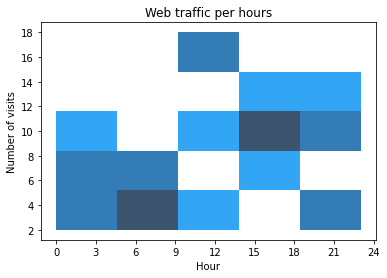

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt


df_logs['time'] = df_logs['time'].astype('datetime64[ns]')
df_logs['hour'] = df_logs.time.dt.hour
trafico_horas = df_logs.groupby(['hour']).size().reset_index(name='num_visits')
trafico_horas_hist = sns.histplot(data=trafico_horas, x="hour", y="num_visits", bins = 5)
range_hours = range(0,25,3)
plt.xticks(range_hours)
plt.title('Web traffic per hours')
plt.ylabel('Number of visits')
plt.xlabel('Hour')
plt.show()

**Tráfico de la web por horas por país**

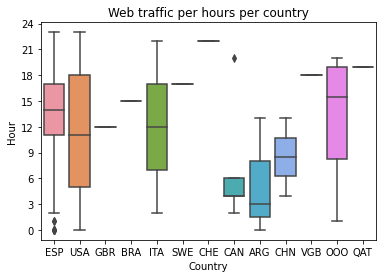

In [29]:
horas_trafico_pais = sns.boxplot(x="country", y="hour", data=df_logs)
range_hours = range(0,25,3)
plt.yticks(range_hours)
plt.title('Web traffic per hours per country')
plt.ylabel('Hour')
plt.xlabel('Country')
plt.show()

**Horas a las que se producen errores**

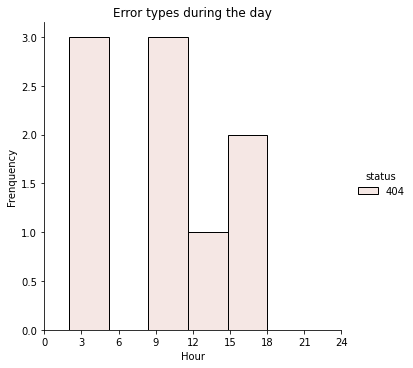

In [30]:
errors = df_logs[df_logs['status'] >= 400]
sns.displot(data=errors, x="hour", hue="status")
range_hours = range(0,25,3)
plt.xticks(range_hours)
plt.title('Error types during the day')
plt.ylabel('Frenquency')
plt.xlabel('Hour')
plt.show()